In [1]:
import math
import torch
from torch import nn
from torch import Tensor
from torch.nn  import functional as F
import gpytorch
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D 
import sys
from decimal import Decimal
from IPython.display import clear_output
sys.path.append("..")
from kernels import vvkernels as vvk, sep_vvkernels as svvk, vvk_rbfkernel as vvk_rbf
from means import vvmeans as vvm
from likelihood import vvlikelihood as vvll
from utils import ObjFun, get_vertices, stopping_criteria
import numpy as np
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Objective function

We sample from $$V_1(x_1, x_2) = 3(1 - x_1)^2 e^{-x_1^2 - (x_2 +1)^2} - 10 (x_1/5 - x_1 ^3 - x_2^5) e^{-x_1^2 - x_2 ^2} - 3 e^{- (x_1 + 2) ^2 - x_2^2} + 0.5(2x_1 + x_2)$$
$$V_2(x_1, x_2) = 3(1 +x_2)^2 e^{-x_2^2 - (x_1 +1)^2} - 10 (-x_2/5 + x_2 ^3 + x_1^5) e^{-x_1^2 - x_2 ^2} - 3 e^{- ( 2- x_2) ^2 - x_1^2} + 0.5(2x_1 + x_2)$$

where $(x_1, x_2) \in [-3, 3]^2$

In [2]:
vf = ObjFun()
f_target = vf.tgt_vec
sample_size = 24
D = vf.D
N = vf.N

vf.low = -3.
vf.high = 3.

high_minus_low = vf.high- vf.low
def g_theta(sample_size, D):
    loc = high_minus_low  * np.random.random_sample((sample_size,2)) + vf.low#(np.random.uniform(low=vf.low, high=vf.high, size=(sample_size, D)))
    return Tensor(loc)
train_x = g_theta(sample_size, D)
noise_value= 0.0002 #noise_free = 0.
def vfield_(x):
    x = x.reshape(x.shape[0],D)
    out = torch.zeros(x.shape[0], N)
    out = vf(x[:,0], x[:,1]) + torch.randn(Tensor(vf(x[:,0], x[:,1])).size()) * math.sqrt(noise_value)
    return out #/torch.max(out)

train_y = vfield_(train_x)

## GP model initialization
We inialize the GP model following https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [3]:
x_train = train_x #loc #torch.linspace(0, 1, 10)
y_train = train_y #v  #torch.stack([torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,], -1)

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood,num_base_kernels):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        a = torch.ones(2,2)
        chol_q = torch.tril(a)
        self.mean_module = vvm.TensorProductSubMean(gpytorch.means.LinearMean(2), num_tasks = 2)  #vvm.TensorProductSubMean(gpytorch.means.LinearMean(2), num_tasks = 2)#vvm.TensorProductSubMean(gpytorch.means.ConstantMean(), num_tasks = 2)  # 
        base_kernels = []
        for i in range(num_base_kernels):
            base_kernels.append(( gpytorch.kernels.RBFKernel() )) #gpytorch.kernels.PolynomialKernel(4)  ##gpytorch.kernels.MaternKernel()# (vvk_rbf.vvkRBFKernel())
#         base_kernels2 = []
#         for i in range(num_base_kernels):
#             base_kernels2.append(gpytorch.kernels.PolynomialKernel(5))  
            
        self.covar_module = svvk.SepTensorProductKernel(base_kernels,num_tasks = 2)
        #self.covar_module = gpytorch.kernels.LCMKernel(base_kernels,num_tasks = 2)

#\         self.covar_module = gpytorch.kernels.MultitaskKernel(
#             gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
#         )
       # self.covar_module = vvk.TensorProductKernel(vvk_rbf.vvkRBFKernel(), a[0,0], a[1,0], a[1,1], num_tasks = 2, rank =1,  task_covar_prior=None)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)
    
    



# Hyperparamaters oprimization

In [4]:
# # ###hyperparameters optimization###
def hyper_opti(g_theta1, agg_data, training_iter,num_base_kernels,noise_value, current_model = None, current_likelihood = None):
    noises = torch.ones(agg_data.shape[0]) * (noise_value) #  torch.zeros(agg_data.shape[0]) # 
    noises = noises.reshape(g_theta1.shape[0], 2)
    
#     if (current_model is not None):
#         likelihood = current_likelihood #vvll.FixedNoiseMultitaskGaussianLikelihood(2, noises) #vvll.FixedNoiseMultitaskGaussianLikelihood(2, noises)  #

#         model = current_model#.get_fantasy_model(g_theta1, agg_data) #MultitaskGPModel(g_theta1, agg_data, likelihood,num_base_kernels)
#         model.set_train_data(g_theta1, agg_data,  strict=False)
#     else:
#         likelihood = vvll.FixedNoiseMultitaskGaussianLikelihood(2, noises) #vvll.TensorProductLikelihood(num_tasks = 2)#vvll.FixedNoiseMultitaskGaussianLikelihood(2, noises) #
#         model = MultitaskGPModel(g_theta1, agg_data, likelihood,num_base_kernels)
        
    likelihood =  vvll.FixedNoiseMultitaskGaussianLikelihood(noises) #vvll.TensorProductLikelihood(num_tasks = 2) #
    model = MultitaskGPModel(g_theta1, agg_data, likelihood,num_base_kernels)    
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(),  lr=0.08) #, weight_decay=0.001)  # Includes GaussianLikelihood parameters
    #mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    for i in range(training_iter):
        optimizer.zero_grad()
        loss, inv_quad = likelihood.get_mll(agg_data,g_theta1, model, likelihood, noise_value)
        loss = -loss
        loss.backward()
        optimizer.step()

    return model, likelihood

# Design parameters and sampling point optimization

In [5]:
class design_opti(nn.Module):
    def __init__(self, sample, x):
        super(design_opti, self).__init__()
        #loc = np.random.random_sample((loc_size,2))
        self.g_theta2 = nn.Parameter(Tensor(sample))
        self.x_design = nn.Parameter(Tensor(x))
    def forward(self):
       
        g_theta2_new = self.g_theta2 #filter_sample(self.g_theta2, 0.009)
        
        return (g_theta2_new), self.x_design

In [6]:
def conduct_design_opti(x0,loc_sample, f_target, g_theta1, agg_data, model, likelihood, training_design_iter, training_param_iter, lr_new,noise_value):
    design = design_opti(loc_sample,x0)
    loc_sample0 = loc_sample
    
    g_theta2, x_d = design.forward()
    def closure():
        optimizer.zero_grad()
        
        loss2, pf1, Qf12 = likelihood.get_ell(agg_data,f_target,x_d, g_theta1, g_theta2, model, likelihood, noise_value)
        
        loss2 = -1. * loss2

        loss2.backward()

       
        return loss2
        
        
        
    optimizer = torch.optim.LBFGS(design.parameters(), lr=lr_new, history_size=100, max_iter=100, line_search_fn="strong_wolfe")
    optimizer.step(closure)
    

    g_theta2, x_d = design.forward()
    loss2, pf1, Qf12 = likelihood.get_ell(agg_data,f_target,x_d, g_theta1, g_theta2, model, likelihood, noise_value)
    loss2 = -1. * loss2
    print('Loss design: %.3f' % ( loss2))
    #print(x_d)
    return x_d, g_theta2, loss2, pf1, Qf12
    
    

# Conducting the TAD experiment

0
START HYPERPARAMETERS optimization
END HYPERPARAMETERS optimization
Loss design: -5.436
Parameter containing:
tensor([[0.5757, 1.1323]], requires_grad=True)
Lower bound 0: 0.282222807407379
Lower bound 1: 0.248904660344124
Upper bound 0: 0.344103872776031
Upper bound 1: 0.337471544742584
tensor([[0.3280],
        [0.3402]])
tensor([[0.3480],
        [0.3602]])
tensor(0.0019)


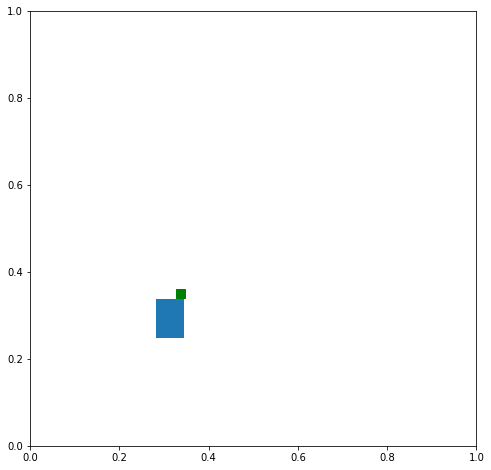

1
START HYPERPARAMETERS optimization
END HYPERPARAMETERS optimization
Loss design: 1.501
Parameter containing:
tensor([[-0.2300, -0.9485]], requires_grad=True)
Lower bound 0: -0.280472725629807
Lower bound 1: -0.202378481626511
Upper bound 0: 0.115658372640610
Upper bound 1: 0.439404517412186
tensor([[0.3280],
        [0.3402]])
tensor([[0.3480],
        [0.3602]])
tensor(0.0569)


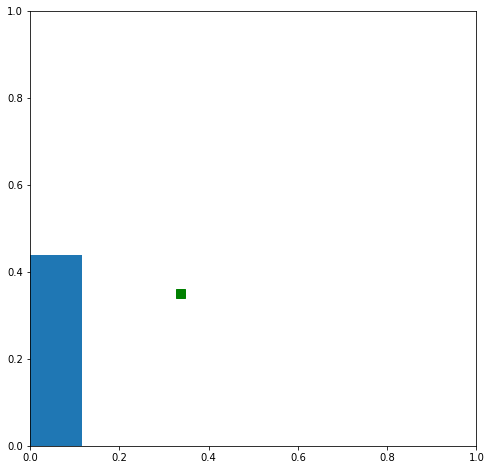

2
START HYPERPARAMETERS optimization
END HYPERPARAMETERS optimization
Loss design: 4.568
Parameter containing:
tensor([[-0.1343, -0.3138]], requires_grad=True)
Lower bound 0: -0.099650338292122
Lower bound 1: 0.083052262663841
Upper bound 0: 0.118402361869812
Upper bound 1: 0.392094492912292
tensor([[0.3280],
        [0.3402]])
tensor([[0.3480],
        [0.3602]])
tensor(0.0228)


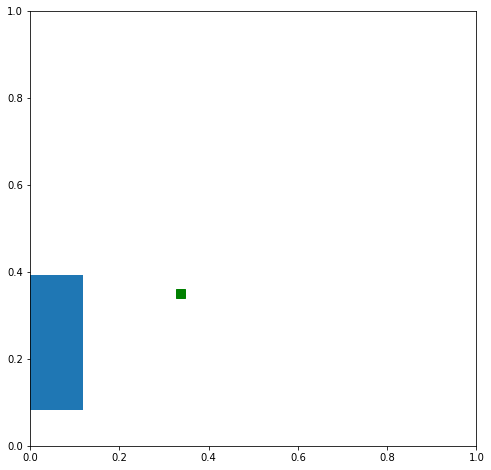

3
START HYPERPARAMETERS optimization
END HYPERPARAMETERS optimization
Loss design: -1.804
Parameter containing:
tensor([[0.8991, 0.7807]], requires_grad=True)
Lower bound 0: 0.264546155929565
Lower bound 1: 0.271967023611069
Upper bound 0: 0.310037851333618
Upper bound 1: 0.327912598848343
tensor([[0.3280],
        [0.3402]])
tensor([[0.3480],
        [0.3602]])
tensor(0.0008)


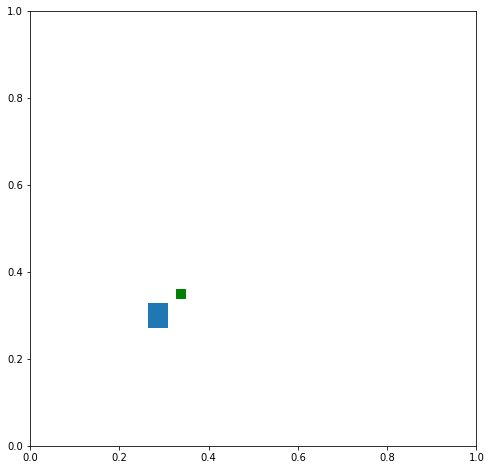

4
START HYPERPARAMETERS optimization
END HYPERPARAMETERS optimization
Loss design: -6.263
Parameter containing:
tensor([[0.8790, 0.7101]], requires_grad=True)
Lower bound 0: 0.297828912734985
Lower bound 1: 0.310203313827515
Upper bound 0: 0.331637203693390
Upper bound 1: 0.347036540508270
tensor([[0.3280],
        [0.3402]])
tensor([[0.3480],
        [0.3602]])
tensor(0.1618)


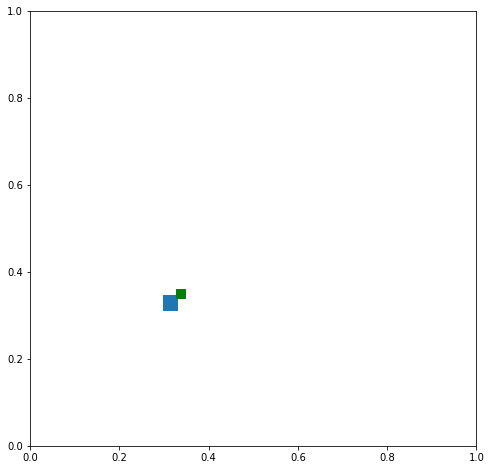

5
START HYPERPARAMETERS optimization
END HYPERPARAMETERS optimization
Loss design: -8.046
Parameter containing:
tensor([[0.8825, 0.6616]], requires_grad=True)
Lower bound 0: 0.316284894943237
Lower bound 1: 0.324948221445084
Upper bound 0: 0.345763564109802
Upper bound 1: 0.355144172906876
tensor([[0.3280],
        [0.3402]])
tensor([[0.3480],
        [0.3602]])
tensor(0.0001)


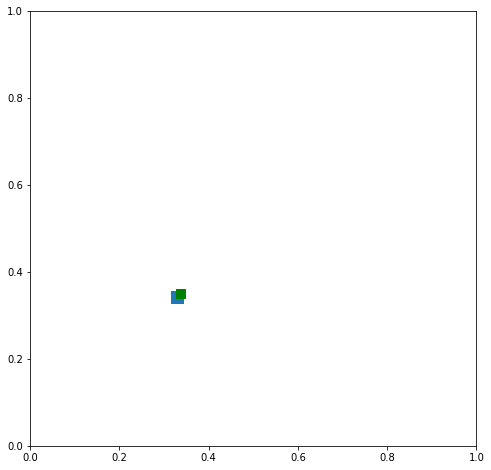

6
START HYPERPARAMETERS optimization
END HYPERPARAMETERS optimization
Loss design: -9.002
Parameter containing:
tensor([[0.8572, 0.6587]], requires_grad=True)
Lower bound 0: 0.326289057731628
Lower bound 1: 0.335709393024445
Upper bound 0: 0.347560286521912
Upper bound 1: 0.356656253337860
tensor([[0.3280],
        [0.3402]])
tensor([[0.3480],
        [0.3602]])
tensor(0.0581)


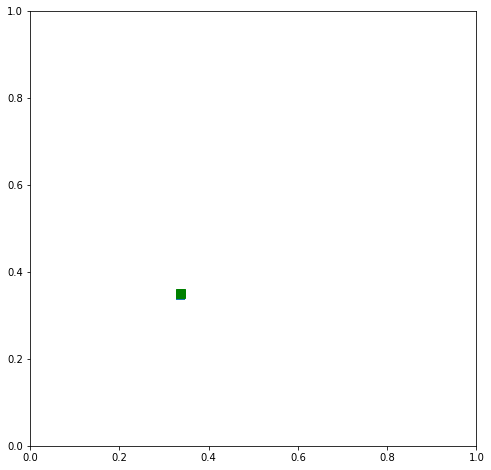

7
START HYPERPARAMETERS optimization
END HYPERPARAMETERS optimization
Loss design: -9.401
Parameter containing:
tensor([[0.8731, 0.6487]], requires_grad=True)
Lower bound 0: 0.326967418193817
Lower bound 1: 0.338447183370590
Upper bound 0: 0.344184219837189
Upper bound 1: 0.355696052312851
tensor([[0.3280],
        [0.3402]])
tensor([[0.3480],
        [0.3602]])
tensor(3.2173e-05)


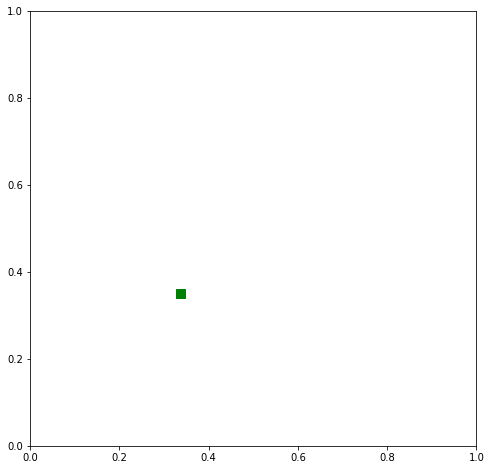

8
START HYPERPARAMETERS optimization
END HYPERPARAMETERS optimization
Loss design: -8.578
Parameter containing:
tensor([[0.8693, 0.5950]], requires_grad=True)
Lower bound 0: 0.321586877107620
Lower bound 1: 0.331525027751923
Upper bound 0: 0.342222481966019
Upper bound 1: 0.351481080055237
tensor([[0.3280],
        [0.3402]])
tensor([[0.3480],
        [0.3602]])
tensor(0.0082)


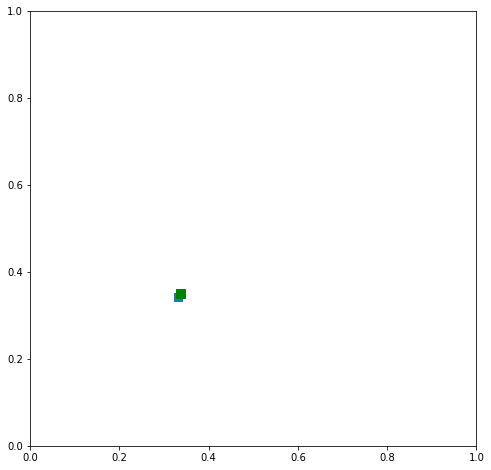

9
START HYPERPARAMETERS optimization
END HYPERPARAMETERS optimization
Loss design: -8.763
Parameter containing:
tensor([[0.8728, 0.5697]], requires_grad=True)
Lower bound 0: 0.322854429483414
Lower bound 1: 0.333231002092361
Upper bound 0: 0.341196507215500
Upper bound 1: 0.351107269525528
tensor([[0.3280],
        [0.3402]])
tensor([[0.3480],
        [0.3602]])
tensor(0.0061)


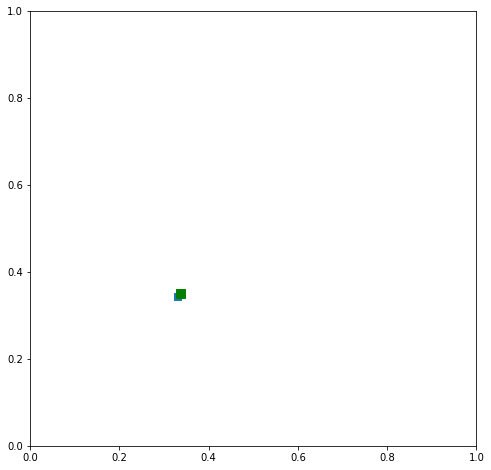

10
START HYPERPARAMETERS optimization
END HYPERPARAMETERS optimization
Loss design: -8.562
Parameter containing:
tensor([[0.8713, 0.5587]], requires_grad=True)
Lower bound 0: 0.322016000747681
Lower bound 1: 0.333427459001541
Upper bound 0: 0.338454246520996
Upper bound 1: 0.349898487329483
tensor([[0.3280],
        [0.3402]])
tensor([[0.3480],
        [0.3602]])
tensor(3.7269e-05)


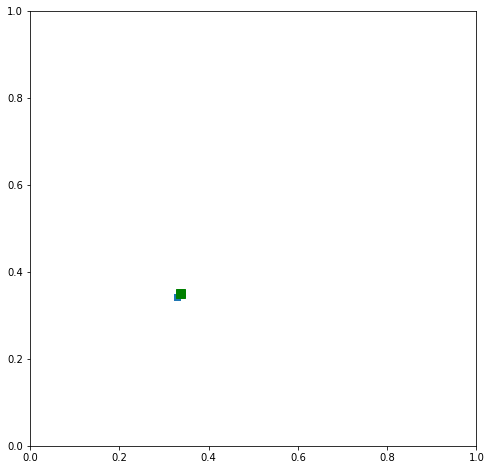

11
START HYPERPARAMETERS optimization
END HYPERPARAMETERS optimization
Loss design: -8.242
Parameter containing:
tensor([[0.8750, 0.5442]], requires_grad=True)
Lower bound 0: 0.321508884429932
Lower bound 1: 0.333550155162811
Upper bound 0: 0.336902558803558
Upper bound 1: 0.348690152168274
tensor([[0.3280],
        [0.3402]])
tensor([[0.3480],
        [0.3602]])
tensor(0.0037)


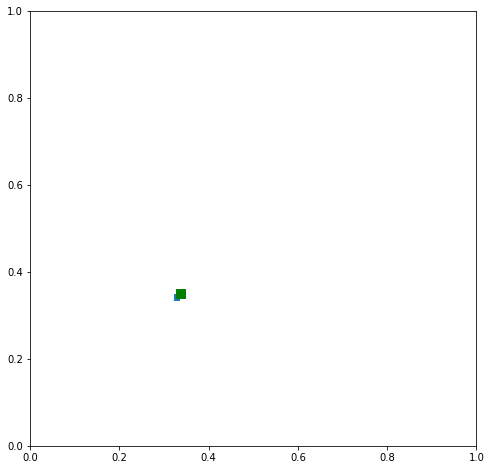

12
START HYPERPARAMETERS optimization
END HYPERPARAMETERS optimization
Loss design: -8.778
Parameter containing:
tensor([[0.8757, 0.5371]], requires_grad=True)
Lower bound 0: 0.324152112007141
Lower bound 1: 0.335830301046371
Upper bound 0: 0.337819278240204
Upper bound 1: 0.349482089281082
tensor([[0.3280],
        [0.3402]])
tensor([[0.3480],
        [0.3602]])
tensor(0.0015)


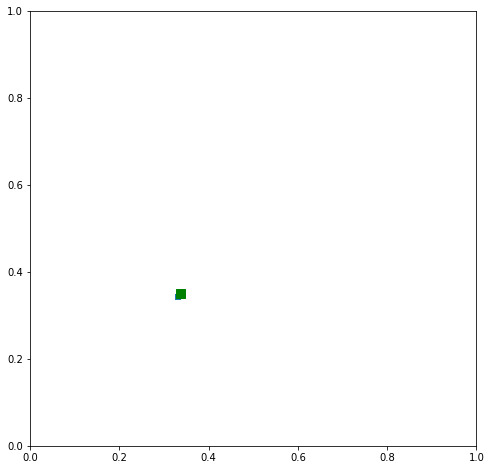

13
START HYPERPARAMETERS optimization
END HYPERPARAMETERS optimization
Loss design: -9.713
Parameter containing:
tensor([[0.8750, 0.5472]], requires_grad=True)
Lower bound 0: 0.327915400266647
Lower bound 1: 0.339934706687927
Upper bound 0: 0.339644461870193
Upper bound 1: 0.351635456085205
tensor([[0.3280],
        [0.3402]])
tensor([[0.3480],
        [0.3602]])
tensor(0.0175)


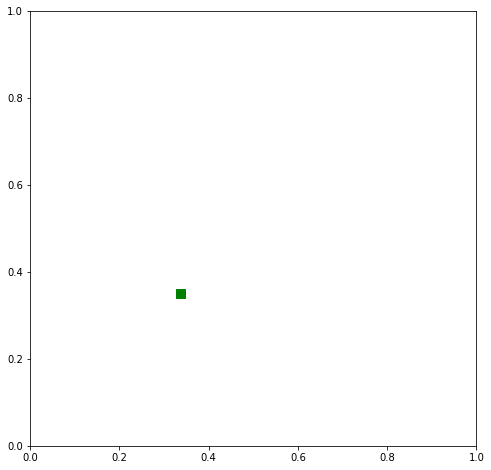

14
START HYPERPARAMETERS optimization
END HYPERPARAMETERS optimization
Loss design: -10.324
Parameter containing:
tensor([[0.8828, 0.5595]], requires_grad=True)
Lower bound 0: 0.330351889133453
Lower bound 1: 0.342691630125046
Upper bound 0: 0.340487182140350
Upper bound 1: 0.352885752916336
tensor([[0.3280],
        [0.3402]])
tensor([[0.3480],
        [0.3602]])
tensor(0.0009)


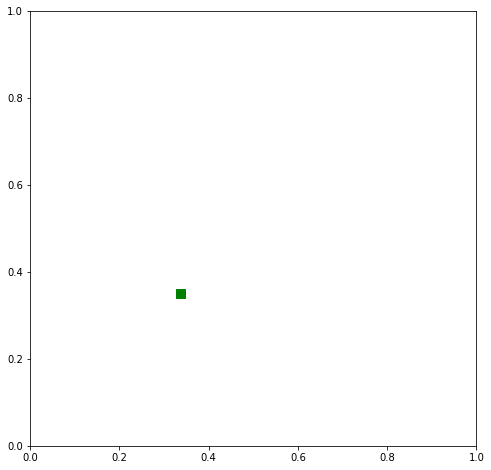

Success is True and failure is False


In [7]:
iter_hp = 50
iter_design = 40 
iter_param = 50
num_base_kernels = 5
max_iter = 50




f_target = f_target.reshape(2,1) 
tol_vector = 0.01 * torch.ones(f_target.shape)

plot_freq = 1

loc_size = 4
loc_sample = high_minus_low  * np.random.random_sample((loc_size,2)) + vf.low #np.random.random_sample((loc_size,2))
loc_sample = Tensor(loc_sample)



g_theta2_vec = (Tensor(loc_sample).clone()).flatten()

g_theta1 = x_train
agg_data = y_train.flatten()


x0 = Tensor(np.array([0.0,0.0])) 
x0 = x0.reshape(1,2)
vec_x = Tensor(np.array([0.0,0.0])) 
vec_x = vec_x.reshape(1,2)
var_vec = torch.zeros([max_iter, 1])

lr_new = 1.

    
    

SUCCESS = False 
FAILURE = False 
iter = 0 

while(SUCCESS == False and FAILURE == False):
    print(iter)
    print('START HYPERPARAMETERS optimization')
    if (iter == 0):
        cur_model = None
        cur_likelihood = None
    
        
        
    model, likelihood = hyper_opti(g_theta1,agg_data,iter_hp,num_base_kernels,noise_value, current_model = cur_model, current_likelihood = cur_likelihood)

    print('END HYPERPARAMETERS optimization')
    
    model.eval()
    likelihood.eval()
    #with gpytorch.settings.fast_pred_var():
    #print(g_theta1)
    x0_new,g_theta2, loss, pf1, Qf12 = conduct_design_opti(x0, loc_sample, f_target, g_theta1, agg_data, model, likelihood, iter_design,iter_param, lr_new,noise_value)
    
    cur_model = model
    cur_likelihood = likelihood
    
    tol_drop = 0.009 #* var
    
    #var_vec[iter] = var
        
    g_theta2_vec = torch.cat([g_theta2_vec, g_theta2.detach().flatten()], 0)
    g_theta2_vec = torch.cat([g_theta2_vec, x0_new.flatten()], 0)
    
    print(( x0_new))
    loc_sample = Tensor(high_minus_low  * np.random.random_sample((loc_size,2)) + vf.low) #np.random.random_sample((loc_size,2))
    
    vec_x = torch.cat([vec_x, x0_new.detach()])
    
    new_data = vfield_(g_theta2.detach())  
    agg_data12 = torch.cat([agg_data, new_data.flatten()], 0)
    g_theta12= torch.cat([g_theta1, g_theta2.detach()], 0)
    new_data_x = vfield_(x0_new.detach() )    
    agg_data = torch.cat([agg_data12, new_data_x.flatten()], 0)
    g_theta1= torch.cat([g_theta12, x0_new.detach()], 0)

#initialize target candidate
    x0 = Tensor(np.array([0.0,0.0])) 
    x0 = x0.reshape(1,2)
    
    lower_bound = torch.zeros(pf1.shape)
    upper_bound = torch.zeros(pf1.shape)
        
    for i in range(pf1.shape[0]):
        lower_bound[i] = pf1[i] -  torch.sqrt(Qf12[i,i])
        upper_bound[i] = pf1[i] +  torch.sqrt(Qf12[i,i])

    iter = iter + 1

    print('Lower bound 0: %.15f'% (lower_bound[0]))
    print('Lower bound 1: %.15f'% (lower_bound[1]))
    print('Upper bound 0: %.15f'% (upper_bound[0]))
    print('Upper bound 1: %.15f'% (upper_bound[1]))
    print(f_target-tol_vector)
    print(f_target+tol_vector)

    SUCCESS = stopping_criteria(tol_vector, f_target, lower_bound, upper_bound)

    #var_vec_out = var_vec.detach()[0:iter - 1]
    
    with torch.no_grad():
        v1,v2,v3,v4 = get_vertices(pf1,Qf12[0,0], Qf12[1,1])
        data_2 = new_data.flatten()
        p_value_ftgt_v1 = likelihood.get_inv_quad(Qf12, v1, g_theta12, agg_data12,x0_new.detach() , model, noise_value) #gpytorch.inv_quad(Qf12, f_target, x0_new.detach(),noise_value ) #
        p_value_ftgt_v2 = likelihood.get_inv_quad(Qf12, v2,g_theta12, agg_data12,x0_new.detach() , model, noise_value)
        p_value_ftgt_v3 = likelihood.get_inv_quad(Qf12, v3,  g_theta12, agg_data12, x0_new.detach() , model, noise_value)
        p_value_ftgt_v4 = likelihood.get_inv_quad(Qf12, v4,  g_theta12, agg_data12,x0_new.detach() , model, noise_value)
        p_value_ftgt = torch.min(Tensor([p_value_ftgt_v1, p_value_ftgt_v2, p_value_ftgt_v3, p_value_ftgt_v4]))
        print(p_value_ftgt)
        if (p_value_ftgt > 13.816):
            FAILURE = True
            
        f, ax = plt.subplots(1, 1, figsize=(8, 8))
        width = 2 * torch.sqrt(Qf12[0,0])
        height = 2 * torch.sqrt(Qf12[1,1])
        ax.add_patch(patches.Rectangle((pf1[0]-torch.sqrt(Qf12[0,0]) , pf1[1] - torch.sqrt(Qf12[1,1])), width, height))
        # Plot predictive means as blue line
        width = 2 * 0.01
        height = 2 * 0.01
        #print(f_target[0])
        ax.add_patch(patches.Rectangle((f_target[0] - 0.01, f_target[1] - 0.01), width, height, color = 'g'))
        plt.show()
        #clear_output(wait=False)
        

    

    
print('Success is ' + str(SUCCESS) + ' and failure is ' + str(FAILURE))

    

In [8]:
#x0 = Tensor(np.array([0.1937, 0.1257]))
#x0 = Tensor(np.array([0.1885, 0.1038]))

x0 = x0_new #Tensor(np.array([0.8734, 0.5585]))
#x0_new = Tensor(np.array([0.8731, 0.5664]))
x0 = x0_new.reshape(1,2)

print(vf(x0[:,0], x0[:,1]))
x0 = x0.reshape(1,2)
print(x0)
model.eval()
likelihood.eval()
# for param in model.named_parameters():
#         print(param)
noises = torch.ones(x0.shape) * (noise_value) 
with torch.no_grad():

    pr = model(x0) #likelihood(model(x0), noise = noises) #
    print(pr.confidence_region())
    print(pr.mean)

tensor([[0.3431, 0.3449]], grad_fn=<CatBackward0>)
tensor([[0.8828, 0.5595]], grad_fn=<ReshapeAliasBackward0>)
(tensor([[-0.0600, -0.2091]]), tensor([[0.7486, 0.6395]]))
tensor([[0.3443, 0.2152]])


In [9]:
v2 = g_theta2_vec.reshape((iter)*(loc_size+1) + loc_size,2)


## RANDOM SEARCH

In [10]:
class design_opti_pll(nn.Module):
    def __init__(self, x):
        super(design_opti_pll, self).__init__()
        #loc = np.random.random_sample((loc_size,2))
        #self.g_theta2 = nn.Parameter(Tensor(sample))
        self.x_design = nn.Parameter(Tensor(x))
    def forward(self):
       
        #g_theta2_new = self.g_theta2 #filter_sample(self.g_theta2, 0.009)
        
        return self.x_design

In [11]:
def conduct_design_pll(x0,f_target, g_theta, agg_data, model, likelihood, training_design_iter, training_param_iter, lr_new):
    design = design_opti_pll(x0)
    loc_sample0 = loc_sample
    x_d = design.forward()
    def closure():
        optimizer.zero_grad()
        
        loss2,lower_bound, upper_bound = likelihood.get_pll(f_target,x_d, g_theta, agg_data, model, likelihood)
        #loss2 = -1. * loss2
        loss2.backward(retain_graph=True)
#         print(x_d)
#         print(lower_bound)
#         print(upper_bound)
       
        return loss2
        
        
        
    optimizer = torch.optim.LBFGS(design.parameters(), lr=lr_new, history_size=100, max_iter=100, line_search_fn="strong_wolfe")
    optimizer.step(closure)

    x_d = design.forward()
    loss2,lower_bound, upper_bound = likelihood.get_pll(f_target,x_d, g_theta, agg_data, model, likelihood)
    #loss2 = -1. * loss2
    print('Loss design: %.3f' % ( loss2))
   # print(optimizer.state_dict())
    print(x_d)
    return x_d, lower_bound, upper_bound

In [12]:
# iter_hp = 30
# iter_design = 40 
# iter_param = 50
# num_base_kernels = 3

# f_target = Tensor(vf.tgt_vec) 
# f_target = f_target.reshape(f_target.shape[0],1) 
# tol_vector = 0.005 * torch.ones(f_target.shape)


loc_size_rdn = (iter + 1)*loc_size + sample_size

loc_sample = high_minus_low  * np.random.random_sample((loc_size_rdn,2)) + vf.low #np.random.random_sample((loc_size_rdn,2))
g_theta_ = (Tensor(loc_sample).clone())
agg_data1 = vfield_(g_theta_)
agg_data1 = agg_data1.flatten()
print(agg_data1.shape)

x0 = Tensor(np.array([0.0,0.0])) 
x0 = x0.reshape(1,2)
x00 = x0 
vec_x_rdn = Tensor(np.array([0.,0.])) 
vec_x_rdn = vec_x_rdn.reshape(1,2)

lr_new = 1.


SUCCESS = False 
FAILURE = False 
 
tol = 0.009 
print('START HYPERPARAMETERS optimization')
model_rdn, likelihood_rdn = hyper_opti(g_theta_,agg_data1,iter_hp,num_base_kernels,noise_value)

print('END HYPERPARAMETERS optimization')

x0_new,lower_bound, upper_bound = conduct_design_pll(x0,f_target, g_theta_, agg_data1, model_rdn, likelihood_rdn, iter_design, iter_param, lr_new)
print(lower_bound)
print(upper_bound)
print(f_target-tol_vector)
print(f_target+tol_vector)
loc_sample = np.random.random_sample((loc_size_rdn,2))


SUCCESS = stopping_criteria(tol_vector, f_target, lower_bound, upper_bound)


print(x0_new)
print(SUCCESS)
sol_rdn = x0_new

torch.Size([176])
START HYPERPARAMETERS optimization
END HYPERPARAMETERS optimization
Loss design: 0.103
Parameter containing:
tensor([[0.8316, 0.6609]], requires_grad=True)
tensor([[0.4184],
        [0.0923]], grad_fn=<CopySlices>)
tensor([[0.5794],
        [0.2126]], grad_fn=<CopySlices>)
tensor([[0.3280],
        [0.3402]])
tensor([[0.3480],
        [0.3602]])
Parameter containing:
tensor([[0.8316, 0.6609]], requires_grad=True)
False


# TAD Plots and Vizualization

## First we vizualize the target function, namely, the contours of the coordinates of the outputs and its norm.

In [13]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('font', size=15)          # controls default text sizes

tensor(1.1785)


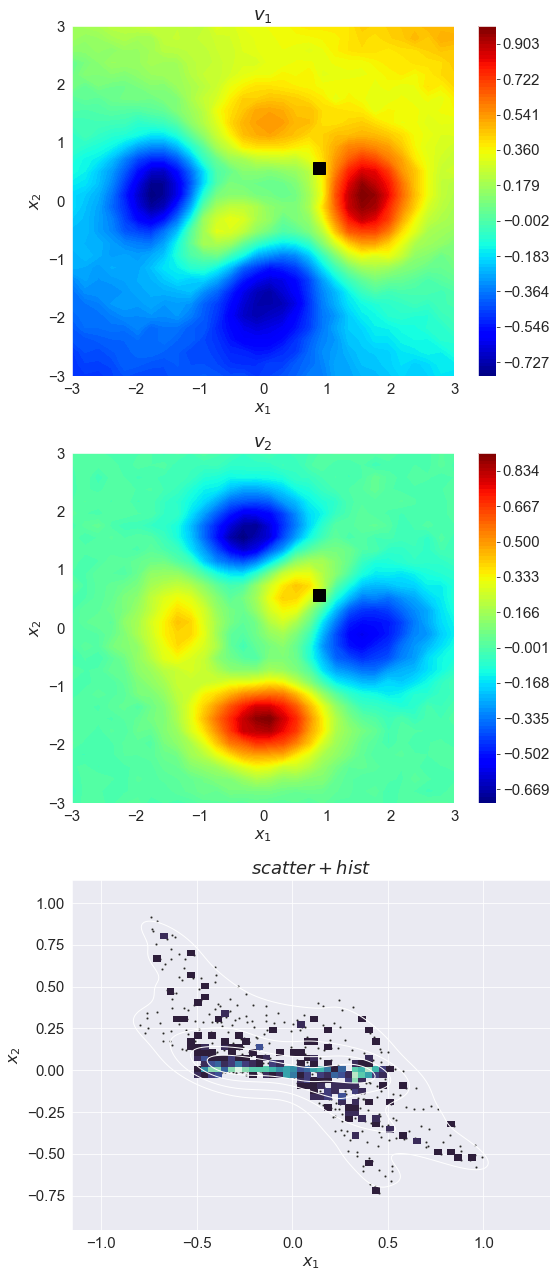

<Figure size 432x288 with 0 Axes>

In [14]:
f_target = Tensor(vf.tgt_vec) 
f_target = f_target.reshape(f_target.shape[0],1)
vf.tgt_loc = vf.tgt_loc.reshape(2,1)
x_plot = np.linspace(vf.low, vf.high, 30)
y_plot = np.linspace(vf.low, vf.high, 30)
xv_plot, yv_plot = np.meshgrid(x_plot, y_plot)
n = x_plot.shape[0]
x_concat = torch.zeros(n * n, 2)
i = 0
k = 0
while i < n*n:
    x_concat[i:i+n,0] = Tensor(xv_plot[:,k])
    x_concat[i:i+n,1] = Tensor(y_plot)
    k = k+1
    i = i+n
out_plot = vfield_(x_concat)


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (8, 18),  tight_layout=True)
v_1 = out_plot[:,0].reshape(n,n)
v_2 = out_plot[:,1].reshape(n,n)
v = np.sqrt(v_1**2 + v_2**2)
print(torch.max(v))

#pos = ax1.imshow(v_1, cmap='RdGy', interpolation='none')

cs1 = ax1.contourf(xv_plot, yv_plot,v_1, np.linspace(v_1.min(), v_1.max(), 100),cmap='jet')
ax1.plot(vf.tgt_loc[0],vf.tgt_loc[1], 'ks', markersize=12)
#cs11 = ax1.contour(xv_plot, yv_plot, v_1,np.linspace(v_1.min(), v_1.max(), 30),colors='w')
ax1.set_title('$v_1$')
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
cs2 = ax2.contourf(xv_plot, yv_plot, v_2, np.linspace(v_2.min(), v_2.max(), 100),cmap='jet')
ax2.plot(vf.tgt_loc[0],vf.tgt_loc[1], 'ks', markersize=12)
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
#cs21 = ax2.contour(xv_plot, yv_plot, v_2,colors='w')
ax2.set_title('$v_2$')
#ax2.set_aspect('equal')
sns.scatterplot(x=out_plot[:,0], y=out_plot[:,1], s=5, color=".15", ax = ax3)    #cs3 = ax3.contourf(xv_plot, yv_plot, v,np.linspace(v.min(), v.max(), 100),cmap='jet')
sns.histplot(x=out_plot[:,0], y=out_plot[:,1], bins=50, pthresh=.1, cmap="mako", ax = ax3)
sns.kdeplot(x=out_plot[:,0], y=out_plot[:,1], levels=5, color="w", linewidths=1, ax = ax3)

#ax3.plot(vf.tgt_loc[0],vf.tgt_loc[1], 'ks', markersize=12)
ax3.set_xlabel('$x_1$')
ax3.set_ylabel('$x_2$')
#cs31 = ax3.contour(xv_plot, yv_plot, v, np.linspace(v.min(), v.max(), 30),colors='w')
ax3.set_title('$scatter+hist$')
#ax3.set_aspect('equal')
cbar1 = fig.colorbar(cs1, ax = ax1);
#cbar1.add_lines(cs11)

cbar2 = fig.colorbar(cs2, ax = ax2);
#cbar2.add_lines(cs21)

#cbar3 = fig.colorbar(cs3, ax = ax3);
#cbar3.add_lines(cs31)
# ax01 = fig.add_subplot(3, 2, 2, projection='3d')
# ax02 = fig.add_subplot(3, 2, 4, projection='3d')
# ax03 = fig.add_subplot(3, 2, 6, projection='3d')

# ax01.plot3D(x_concat[:,0], x_concat[:,1], out_plot[:,0])

# ax02.plot3D(x_concat[:,0], x_concat[:,1], out_plot[:,1])



# ax03.plot3D(x_concat[:,0], x_concat[:,1], np.sqrt( (out_plot[:,1])**2 + (out_plot[:,0])**2))

plt.show()
plt.savefig('figures/target_fun.png')
# cs = plt.contourf(v_1, levels=[10, 30, 50],
#     colors=['#808080', '#A0A0A0', '#C0C0C0'], extend='both')
# cs.cmap.set_over('red')


In [15]:
print(loc_size_rdn)


88


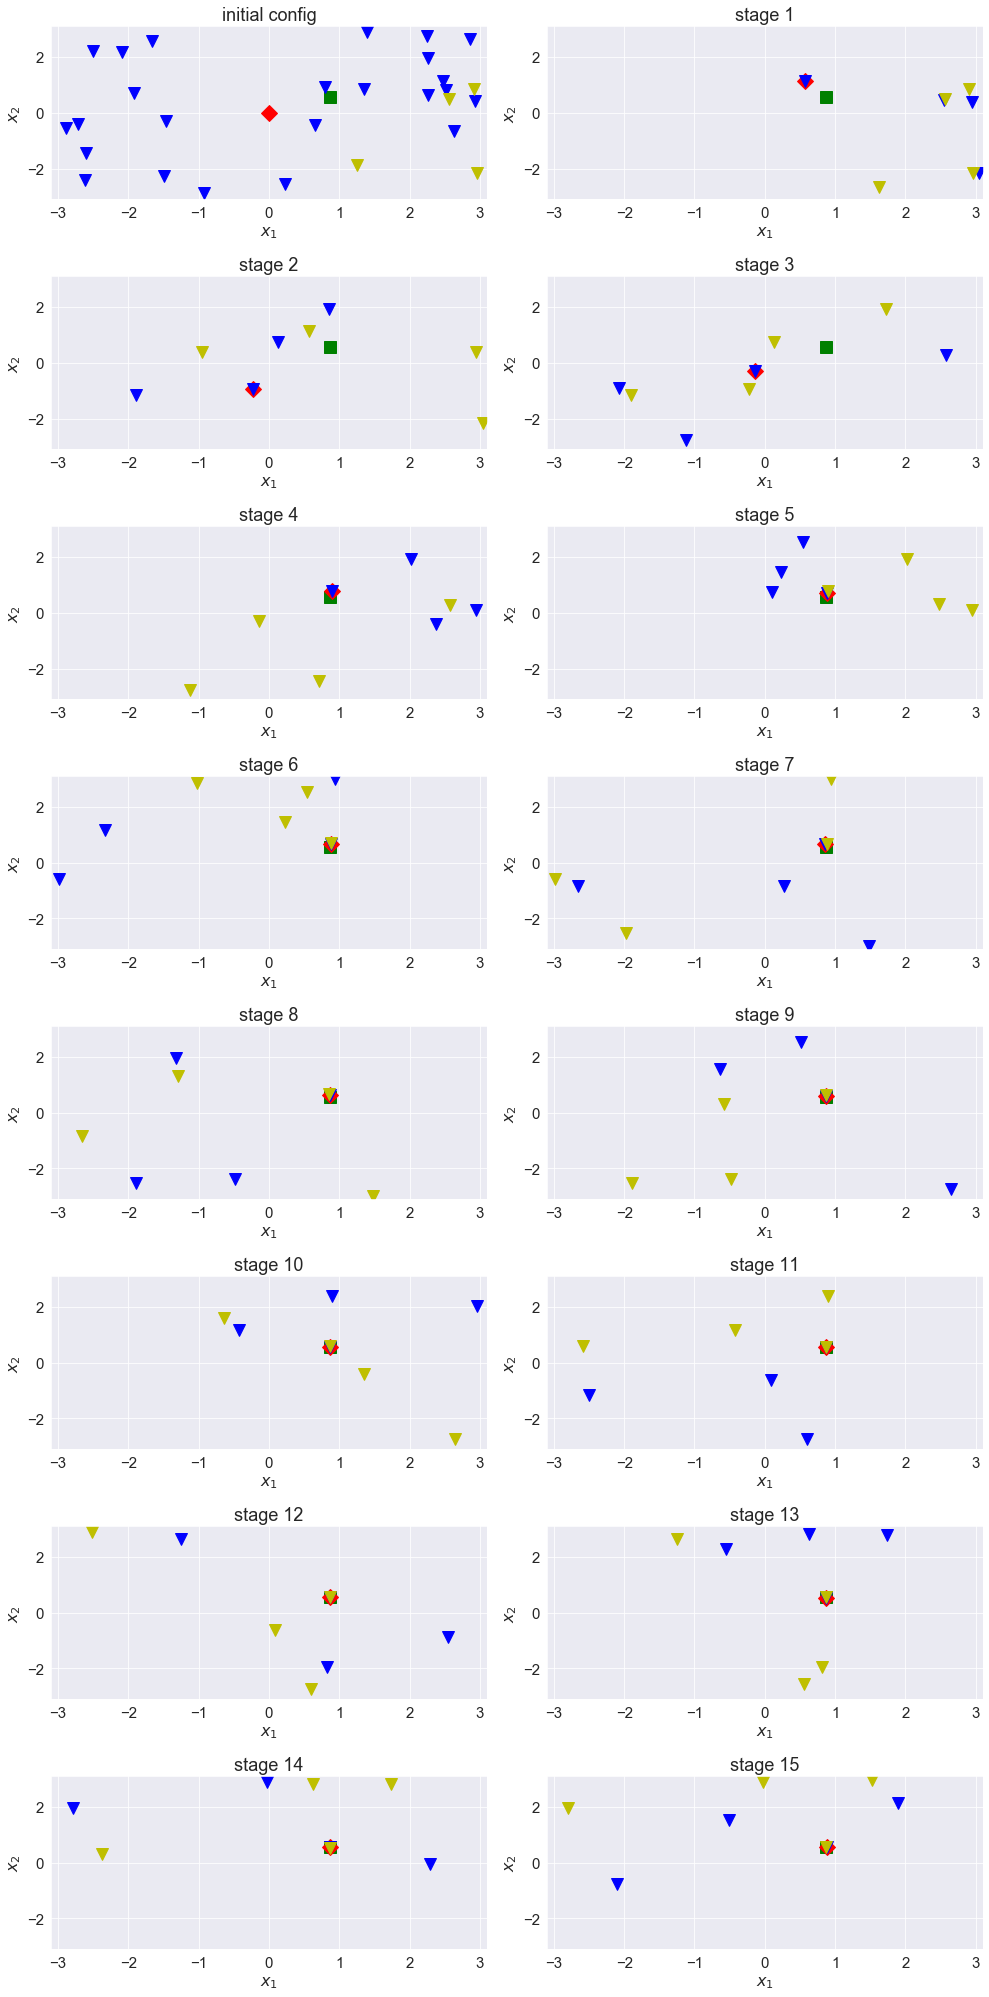

<Figure size 432x288 with 0 Axes>

In [16]:
loc_size = 4
i,j=0,0
low = -3.1
high = 3.1
PLOTS_PER_ROW = 2
widths = 16* np.ones((PLOTS_PER_ROW))
heights = 16 * np.ones((math.ceil((iter + 1)/PLOTS_PER_ROW)))
#print(heights)
gs_kw = dict(width_ratios=widths, height_ratios=heights)
#fig, ax = plt.subplots(math.ceil((iter + 1)/PLOTS_PER_ROW),PLOTS_PER_ROW, constrained_layout=True,
#                             gridspec_kw=gs_kw)
fig, axs = plt.subplots(math.ceil((iter+1)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(14, 28),  tight_layout=True)
ii = 0
# vec_x = Tensor([[0.5000, 0.7000],
#         [0.1427, 0.2234],
#         [0.1859, 0.1796],
#         [0.2023, 0.0953],
#         [0.1999, 0.0963],
#         [0.2003, 0.0998]])
col = 0

vec_x = vec_x.detach()
axs[i][j].plot(0.8731, 0.5664,'gs',markersize=12)
axs[i][j].plot(vec_x[col,0], vec_x[col,1],'rD',markersize=12)
axs[i][j].plot(x_train.detach()[:,0], x_train.detach()[:,1], 'bv', markersize=12)
axs[i][j].plot(v2.detach()[ii:ii+loc_size,0], v2.detach()[ii:ii+loc_size,1], 'yv', markersize=12)
axs[i][j].set_xlabel('$x_1$')
axs[i][j].set_ylabel('$x_2$')
axs[i][j].set_title('initial config')

#axs[i][j].set_aspect('equal')
if (ii > 0):
    axs[i][j].plot(v2.detach()[(ii-loc_size):ii,0], v2.detach()[ii-loc_size:ii,1], 'yv', markersize=12)
axs[i][j].set_xlim(low, high)
axs[i][j].set_ylim(low, high)
ii = ii+loc_size+1
j+=1

loc_size = loc_size
for col in range(1, iter+1):
    axs[i][j].plot(0.8731, 0.5664,'gs',markersize=12)
    axs[i][j].plot(vec_x[col,0], vec_x[col,1],'rD',markersize=12)
    axs[i][j].plot(v2.detach()[ii:ii+loc_size,0], v2.detach()[ii:ii+loc_size,1], 'bv', markersize=12)
  #  axs[i][j].set_aspect('equal')
    if (ii > loc_size):
        axs[i][j].plot(v2.detach()[(ii-loc_size):ii,0], v2.detach()[ii-loc_size:ii,1], 'yv', markersize=12)
    axs[i][j].set_xlim(low, high)
    axs[i][j].set_ylim(low, high)
    axs[i][j].set_xlabel('$x_1$')
    axs[i][j].set_ylabel('$x_2$')
    axs[i][j].set_title('stage %s' % col)
    ii = ii+loc_size+1
    j+=1
    
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
plt.show()
plt.savefig('figures/evol_sol.png')

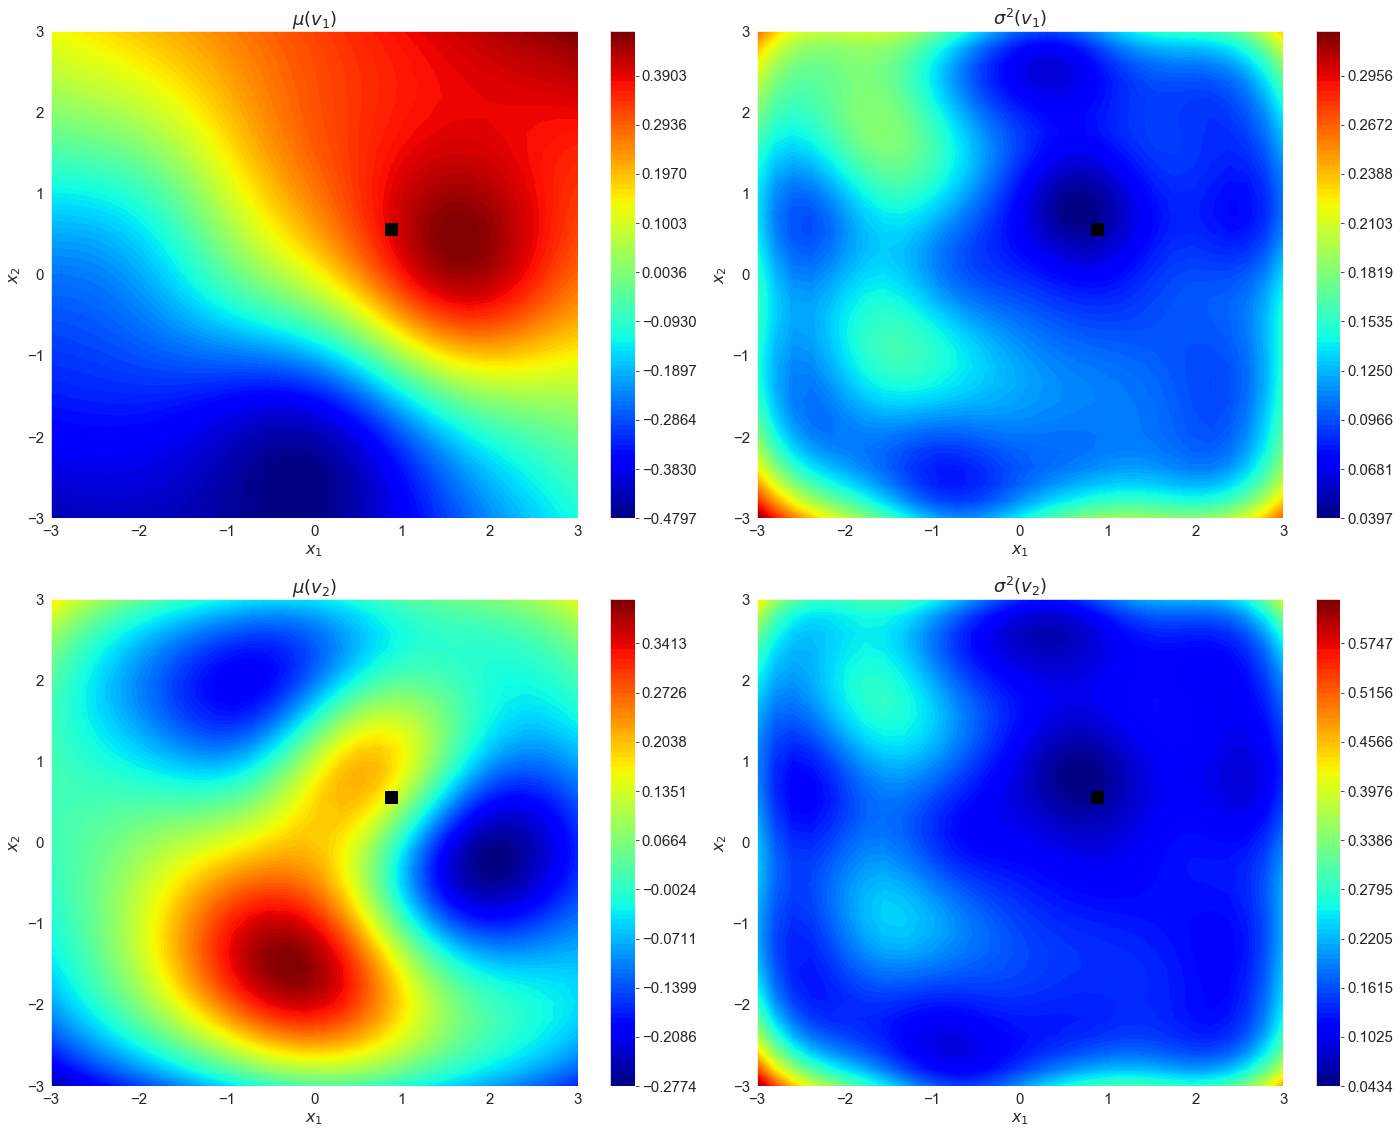

In [17]:
#x0 = Tensor(np.array([0.1937, 0.1257]))
#x0 = Tensor(np.array([0.1885, 0.1038]))
x_plot = np.linspace(vf.low, vf.high, 30)
y_plot = np.linspace(vf.low, vf.high, 30)
xv_plot, yv_plot = np.meshgrid(x_plot, y_plot)
n = x_plot.shape[0]
x_concat_ = torch.zeros(n * n, 2)
i = 0
k = 0
while i < n*n:
    x_concat_[i:i+n,0] = Tensor(xv_plot[:,k])
    x_concat_[i:i+n,1] = Tensor(y_plot)
    k = k+1
    i = i+n
model.eval()
likelihood.eval()
with torch.no_grad():
    pr = model(x_concat_) #likelihood(model(x_concat_), noise = torch.ones(x_concat_.shape) * noise_value)# 

    mean_v_1 = pr.mean[:,0].reshape(n,n)
    mean_v_2 = pr.mean[:,1].reshape(n,n)


    var_v_1 = pr.variance[:,0].reshape(n,n)
    var_v_2 = pr.variance[:,1].reshape(n,n)

fig, (ax1, ax2) = plt.subplots(2, 2, figsize = (20, 16), tight_layout=True)
cs10 = ax1[0].contourf(xv_plot, yv_plot, mean_v_1.detach(),np.linspace(mean_v_1.detach().min(), mean_v_1.detach().max(), 100), cmap = 'jet')
ax1[0].plot(vf.tgt_loc[0],vf.tgt_loc[1], 'ks', markersize=12)
ax1[0].set_title('$\mu(v_1)$', fontsize = 18)
cbar10 = fig.colorbar(cs10, ax = ax1[0]);

ax1[0].set_xlabel('$x_1$', fontsize = 16)
ax1[0].set_ylabel('$x_2$', fontsize = 16)

cs11 = ax1[1].contourf(xv_plot, yv_plot, var_v_1.detach(), np.linspace(var_v_1.detach().min(), var_v_1.detach().max(), 100), cmap = 'jet')
ax1[1].plot(vf.tgt_loc[0],vf.tgt_loc[1], 'ks', markersize=12)
ax1[1].set_title('$\sigma^2(v_1)$', fontsize = 18)
# ax1[0].set_aspect('equal')
# ax1[1].set_aspect('equal')
cbar11 = fig.colorbar(cs11, ax = ax1[1]);
ax1[1].set_xlabel('$x_1$', fontsize = 16)
ax1[1].set_ylabel('$x_2$', fontsize = 16)


cs20 = ax2[0].contourf(xv_plot, yv_plot, mean_v_2.detach(),np.linspace(mean_v_2.detach().min(), mean_v_2.detach().max(), 100), cmap = 'jet')
ax2[0].plot(vf.tgt_loc[0],vf.tgt_loc[1], 'ks', markersize=12)
ax2[0].set_title('$\mu(v_2)$', fontsize = 18)
cbar20 = fig.colorbar(cs20, ax = ax2[0]);
ax2[0].set_xlabel('$x_1$', fontsize = 16)
ax2[0].set_ylabel('$x_2$', fontsize = 16)



cs21 = ax2[1].contourf(xv_plot, yv_plot, var_v_2.detach(), np.linspace(var_v_2.detach().min(), var_v_2.detach().max(), 100), cmap = 'jet')
ax2[1].plot(vf.tgt_loc[0],vf.tgt_loc[1], 'ks', markersize=12)
ax2[1].set_title('$\sigma^2(v_2)$', fontsize = 18)
cbar21 = fig.colorbar(cs21, ax = ax2[1]);
ax2[1].set_xlabel('$x_1$', fontsize = 16)
ax2[1].set_ylabel('$x_2$', fontsize = 16)


# ax2[0].set_aspect('equal')
# ax2[1].set_aspect('equal')

plt.savefig('figures/mean_var.png')


# Grid


In [18]:
loc_size= 4

In [19]:
x_plot = np.linspace(vf.low, vf.high, 15)
y_plot = np.linspace(vf.low, vf.high, 15)
xv_plot, yv_plot = np.meshgrid(x_plot, y_plot)
n = x_plot.shape[0]
x_concat = torch.zeros(n * n, 2)
i = 0
k = 0
while i < n*n:
    x_concat[i:i+n,0] = Tensor(xv_plot[:,k])
    x_concat[i:i+n,1] = Tensor(y_plot)
    k = k+1
    i = i+n

g_theta_grid = x_concat
agg_data1_grid = vfield_(g_theta_grid)
agg_data1_grid = agg_data1_grid.flatten()


x0 = Tensor(np.array([0.0,0.0])) 
x0 = x0.reshape(1,2)
x00 = x0 
vec_x_grid = Tensor(np.array([0.0,0.0])) 
vec_x_grid = vec_x_grid.reshape(1,2)

lr_new = 1.

SUCCESS = False 
FAILURE = False 
 
tol = 0.009 
print('START HYPERPARAMETERS optimization')
model_grid, likelihood_grid = hyper_opti(g_theta_grid,agg_data1_grid,iter_hp,num_base_kernels,noise_value)

print('END HYPERPARAMETERS optimization')

x0_new,lower_bound, upper_bound = conduct_design_pll(x0,f_target, g_theta_grid, agg_data1_grid, model_grid, likelihood_grid, iter_design, iter_param, lr_new)
print(lower_bound)
print(upper_bound)
print(f_target-tol_vector)
print(f_target+tol_vector)
#loc_sample = np.random.random_sample((loc_size_rdn,2))


SUCCESS = stopping_criteria(tol_vector, f_target, lower_bound, upper_bound)


print(x0_new)
print(SUCCESS)

START HYPERPARAMETERS optimization
END HYPERPARAMETERS optimization


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  NumericalWarning,


Loss design: 45999.730
Parameter containing:
tensor([[0.0038, 0.2028]], requires_grad=True)
tensor([[0.0971],
        [0.1888]], grad_fn=<CopySlices>)
tensor([[0.0991],
        [0.1906]], grad_fn=<CopySlices>)
tensor([[0.3280],
        [0.3402]])
tensor([[0.3480],
        [0.3602]])
Parameter containing:
tensor([[0.0038, 0.2028]], requires_grad=True)
False


Text(43.875, 0.5, '$x_2$')

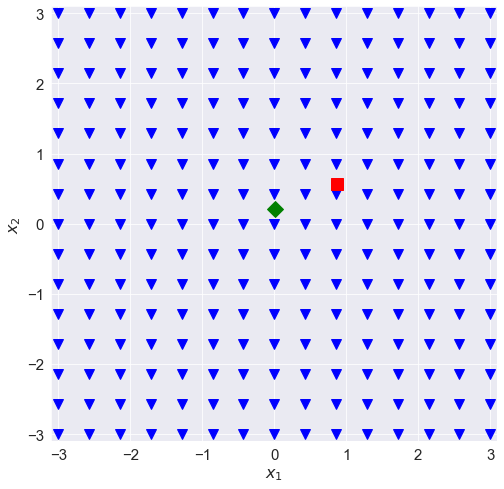

In [20]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(x_concat[:,0],x_concat[:,1], 'bv',markersize=10)
ax.plot(x0_new.detach()[0,0], x0_new.detach()[0,1],'gD',markersize=12)
ax.plot(0.8731, 0.5664,'rs',markersize=12)
plt.savefig('figures/grid_sol.eps')
ax.set_xlim(-3.1, 3.1)
ax.set_ylim(-3.1, 3.1)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

Text(43.875, 0.5, '$x_2$')

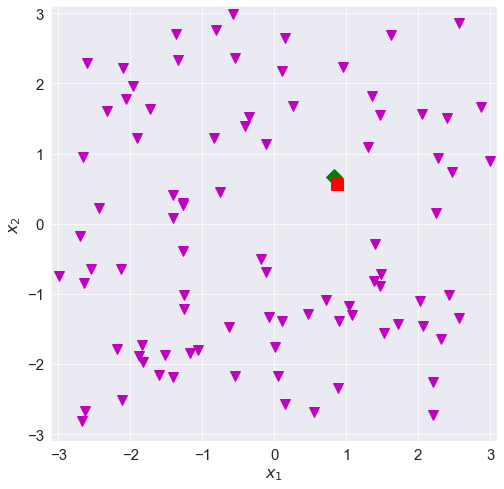

In [21]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(g_theta_[:,0].detach(),g_theta_[:,1].detach(), 'mv',markersize=10)
ax.plot(sol_rdn.detach()[0,0], sol_rdn.detach()[0,1],'gD',markersize=12)
ax.plot(0.8731, 0.5664,'rs',markersize=12)
plt.savefig('figures/rdn_sol.eps')
ax.set_xlim(-3.1, 3.1)
ax.set_ylim(-3.1, 3.1)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

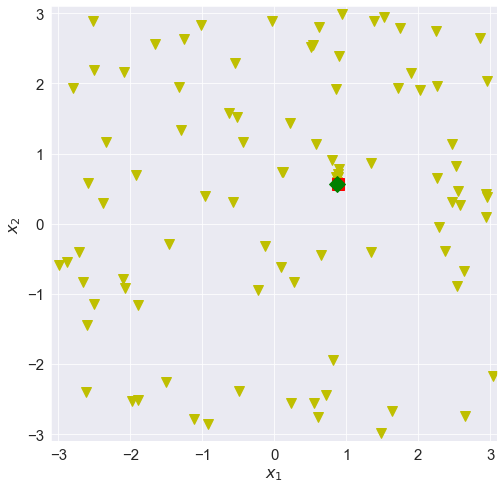

In [22]:
fig, ax = plt.subplots(figsize = (8,8))
ax.set_xlim(-3.1, 3.1)
ax.set_ylim(-3.1, 3.1)
ax.plot(g_theta1[:, 0].detach(),g_theta1[:, 1].detach() , 'yv',markersize=10)
ax.plot(vec_x[iter,0], vec_x[iter,1],'rs',markersize=12)
ax.plot(0.8731, 0.5664,'gD',markersize=12)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.savefig('figures/tad_sol_allpoints.eps')
plt.show()

## 